<a href="https://colab.research.google.com/github/dp457/Graph-Neural-Network/blob/main/Adversarially_Regularized_Graph_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Cora dataset is used and the dataset is split into training, testing and validation.
2. Two layer GCN encoder is used that outputs node wise Gaussian parameter $\mu (x)$ and $\log \sigma (x)$  i.e. a variational encoder.
3. MLP discriminator is used used by adversarial regularizer to push the latent features into a simple prior.
4. Training done with reconstruction loss + adversarial regularization + KL term.
5. Evaluates AUC/AP for link prediction and runs k-means on z for clustering metrics and t-SNE for a 2-D plot.


In [8]:
!pip install torch_geometric

In [9]:
import os.path as osp

import matplotlib.pyplot as plt
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import (
    completeness_score,
    homogeneity_score,
    v_measure_score,
)
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ARGVA, GCNConv

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([                 # Compose is a wrapper that allows you to apply multiple transforms sequentially applied to graph dataset
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
]) # 5% edges for validation, 10% edges for testing, undirected graphs, negative samples for training which are disabled, labels where edge is postive or negative
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]

# Encoder - Variational GCN

This implements a two-layer GCN encoder. In the paper, a layer is

$H^{(\ell+1)} = \phi \left( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(\ell)} W^{(\ell)} \right),$

where, $\tilde{A} = A + I$, $\tilde{D}_{ii} = \sum_{j} \tilde{A}_{ij}$ and $\phi$ is ReLU or linear. Here, $H^{(0)}= X$. Second layer branches to $\mu$ and $\log \sigma$, papers encoder with a shared first layer, and two heads for mean and log-std.

**Variational posterior**

For each node $i$, $q_{\phi}(z_i | X,A) = \mathcal{N} (z_i | \mu, \text{diag} (\sigma^2_i))$. The sampling is done using $z_i = \mu_i + \sigma_i \odot \epsilon, \epsilon \sim \mathcal{N}(0, \mathbf{I}).$ This is the ARGVA encoder.

In [10]:
class Encoder(torch.nn.Module): # sees the training graph to generate Z
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Decoder = inner-product Bernoulli graph model

Decoder reconstructs the links from $Z$ with the inner product

$p(A_{ij} = 1 \mid z_i, z_j) = \sigma(z_i^{\top} z_j),
\quad \hat{A} = \sigma(ZZ^{\top}).$





In [11]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
        return self.lin3(x)

Initializing the loss functions

In [12]:
encoder = Encoder(train_data.num_features, hidden_channels=32, out_channels=32)
discriminator = Discriminator(in_channels=32, hidden_channels=64,
                              out_channels=32)
model = ARGVA(encoder, discriminator).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.001)

# Training Objective

## Adversarial regularization to match the aggregated posterior to the prior.

The discriminator $D$ is trained to tell apart
1.   Samples from prior $p(z)$
2.   Samples from encoder $q(z | X,A)$

Discriminator objective is the binary cross entropy loss given as,

$\max_{D} \; \mathbb{E}_{a \sim p(z)} \left[ \log D(a) \right]
+ \mathbb{E}_{z \sim q_{\phi}} \left[ \log \left( 1 - D(z) \right) \right],$

Encoder acts as the generator to fool the discriminator

$\min_{G} \; \max_{D} \;
\mathbb{E}_{a \sim p(z)} \left[ \log D(a) \right]
+ \mathbb{E}_{z \sim q_{\phi}} \left[ \log \left( 1 - D(z) \right) \right].$

Here the discriminator $D$ is trained for $K$ steps per encoder step.

Without adversarial regularization, the latent variables can drift or collapse. The adversarial game shapes the aggregated posterior as

$q(z) = \frac{1}{N} \sum_i q(z_i | X,A) $ to match $p(z)$ which improves the robustness and the clustering structure.

The ARGVA regularization objective is given as,

$\underbrace{- \mathbb{E}_{q_{\phi}(Z \mid X, A)} \big[ \log p_{\theta}(A \mid Z) \big]}_{\text{reconstruction}}
+ \; \lambda_{\text{adv}} \, \mathcal{L}_{\text{adv}}(q_{\phi}, D)
+ \underbrace{\tfrac{1}{N} \, \text{KL}\!\left[ q_{\phi}(Z \mid X, A) \,\|\, p(Z) \right]}_{\text{VAE regularizer}},$

## Closed form KL loss

$\mathrm{KL}\!\left[ \mathcal{N}(\mu, \mathrm{diag}(\sigma^2)) \,\|\, \mathcal{N}(0, I) \right]
= \frac{1}{2} \sum_{j=1}^{d} \left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right).$

The loss calculates the node wise loss and the it has been averaged overall.


In [13]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We optimize the discriminator more frequently than the encoder.
    for _ in range(5):
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z)
        discriminator_loss.backward()
        discriminator_optimizer.step()

    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss = loss + model.reg_loss(z)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    encoder_optimizer.step()
    return float(loss.detach())

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0,
                    n_init='auto').fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.pos_edge_label_index,
                         data.neg_edge_label_index)

    return auc, ap, completeness, hm, nmi


With an inner-product decoder and Bernoulli likelihood, the negative log-likelihood over observed positive edges $\mathcal{E}^+$ and sampled negatives $\mathcal{E}^-$ is,

$\mathcal{L}_{\text{rec}} =
- \sum_{(i,j) \in \mathcal{E}^+} \log \sigma(z_i^{\top} z_j)
- \sum_{(i,j) \in \mathcal{E}^-} \log \big( 1 - \sigma(z_i^{\top} z_j) \big)$

The significance of KL and adversarial term

1. KL term regularizes the node-wise posterior $q(z_i \mid X, A)$ towards $p(z).$
2. The adversarial term matches the aggregated posterior to $p(z).$

Together they reduce posterior drift and yield latents that are both globally well-shaped and locally reasonable, which improves link prediction and clustering, as reported in the paper’s experiments.


Epoch: 001, Loss: 5.529, AUC: 0.736, AP: 0.750, Completeness: 0.082, Homogeneity: 0.084, NMI: 0.083
Epoch: 002, Loss: 5.142, AUC: 0.712, AP: 0.742, Completeness: 0.088, Homogeneity: 0.087, NMI: 0.088
Epoch: 003, Loss: 4.784, AUC: 0.700, AP: 0.736, Completeness: 0.067, Homogeneity: 0.065, NMI: 0.066
Epoch: 004, Loss: 4.410, AUC: 0.695, AP: 0.734, Completeness: 0.070, Homogeneity: 0.068, NMI: 0.069
Epoch: 005, Loss: 4.102, AUC: 0.692, AP: 0.733, Completeness: 0.052, Homogeneity: 0.051, NMI: 0.052
Epoch: 006, Loss: 3.902, AUC: 0.690, AP: 0.732, Completeness: 0.051, Homogeneity: 0.048, NMI: 0.050
Epoch: 007, Loss: 3.606, AUC: 0.691, AP: 0.733, Completeness: 0.054, Homogeneity: 0.051, NMI: 0.053
Epoch: 008, Loss: 3.259, AUC: 0.696, AP: 0.738, Completeness: 0.067, Homogeneity: 0.066, NMI: 0.067
Epoch: 009, Loss: 3.096, AUC: 0.707, AP: 0.746, Completeness: 0.075, Homogeneity: 0.074, NMI: 0.074
Epoch: 010, Loss: 2.889, AUC: 0.725, AP: 0.761, Completeness: 0.085, Homogeneity: 0.083, NMI: 0.084


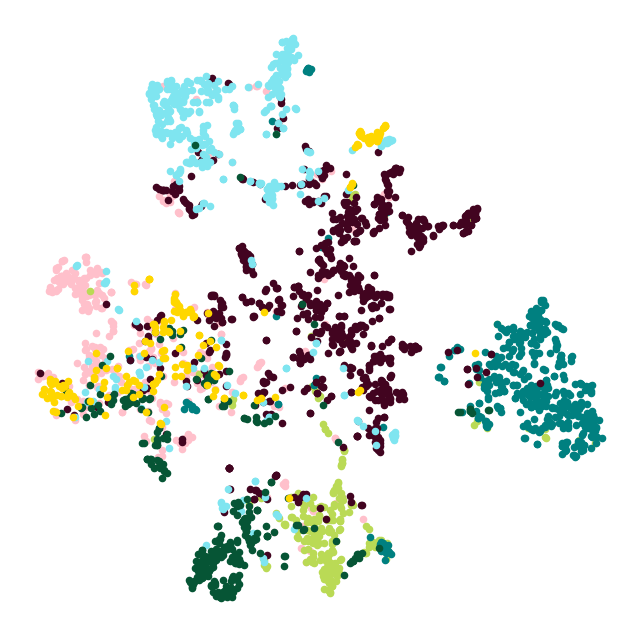

In [14]:
for epoch in range(1, 151):
    loss = train()
    auc, ap, completeness, hm, nmi = test(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
          f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
          f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}')


@torch.no_grad()
def plot_points(data, colors):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(test_data, colors)
